In [1]:
import galsim
import batsim
import numpy as np
import numpy.lib.recfunctions as rfn
import matplotlib
import matplotlib.pyplot as plt
import fpfs
import glob
from time import time

from tqdm import tqdm, trange

### FPFS shapelet kernel size and effective measurement radius
- Deconvolved galaxy Fourier power function is projected onto shapelet basis vectors
- FPFS parameter $\beta = \sigma_{shp} / r_{pp}$, where $r_{pp}$ is the scale radius of the of the PSF Fourier power function
- Prior tests appear to indicate the shapelet scale - measurement radius relationship will vary on a per galaxy basis

In [17]:
# Read in galaxy images with IA
sim_dir = 'simulations/isolated_noiseless'
file_list = glob.glob(sim_dir + '/*.fits')

use_all = False
if not use_all:
    ngals = 4000
    np.random.seed(42)
    inds = np.random.choice(len(file_list), ngals, replace=False)
else:
    inds = np.arange(len(file_list))

cosmos = galsim.COSMOSCatalog()
records = cosmos.getParametricRecord(np.arange(len(cosmos)))

# Stich images together to speed up shear estimation
hlrs = []
use_bulge = []
fluxes = []
hlr_cut = 0.2
progress = tqdm(total=len(inds))
for i, ind in enumerate(inds):

    gal_id = int(file_list[ind].split('/COSMOS_')[-1].split('_')[0])
    
    record_ind = np.where(records['IDENT'] == gal_id)[0][0]
    bulge = records['use_bulgefit'][record_ind]
    use_bulge.append(bulge)

    if bulge:
        hlrs.append(records['hlr'][record_ind][2])
        fluxes.append(records['flux'][record_ind][3])
    else:
        hlrs.append(records['hlr'][record_ind][0])
        fluxes.append(records['flux'][record_ind][0])

    # skip galaxies below a certain size
    if hlrs[-1] < hlr_cut:
        # remove entry from lists
        hlrs.pop(-1)
        use_bulge.pop(-1)
        fluxes.pop(-1)
        progress.update(1)
        continue

    if i == 0:
        gal_array = galsim.fits.read(file_list[ind]).array
        gal_scene = gal_array[:gal_array.shape[0]//2, :gal_array.shape[1]//2]
    else:
        gal_array = galsim.fits.read(file_list[ind]).array
        gal_scene = np.concatenate((gal_scene, gal_array[:gal_array.shape[0]//2, :gal_array.shape[1]//2]), axis=1)

    progress.update(1)
    
progress.close()

100%|██████████| 4000/4000 [01:51<00:00, 35.85it/s]


Number of galaxies: 2195


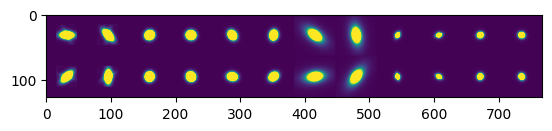

In [18]:
ngals = len(hlrs)
print(f'Number of galaxies: {ngals}')
norm = matplotlib.colors.Normalize(vmin=np.min(gal_scene), vmax=np.max(gal_scene)/5e3, clip=True)
plt.imshow(gal_scene[:,:128*6], norm=norm)

In [19]:
print(gal_scene.shape)

(128, 280960)


In [20]:
scale = galsim.fits.read(file_list[0]).scale
scene_nx = gal_scene.shape[0]
scene_ny = gal_scene.shape[1]
nn = scene_ny // (2*ngals)

a_ia = galsim.Shear(e1=0.00136207, e2=0).g1
b_ia = 0.82404653
print(scale, scene_nx, scene_ny, nn, a_ia)

0.2 128 280960 64 0.0006810353158702314


In [21]:
seeing = 0.67
psf = galsim.Moffat(beta=3.5, fwhm=seeing, trunc=seeing*4)
rcut = 16
psf_data = psf.shift(0.5*scale, 0.5*scale).drawImage(nx=nn, ny=nn, scale=scale, method='auto')

In [22]:
# FPFS measurement function
def test_kernel_size(sigma_arcsec, psf_arr, gal_scene, scale, nx, ny, rcut, true_shear=None):

    # initialize FPFS shear measurement task
    fpTask = fpfs.image.measure_source(psf_arr, sigma_arcsec=sigma_arcsec, pix_scale=scale)

    scene_nx = gal_scene.shape[0]
    scene_ny = gal_scene.shape[1]
    
    # force detection in specific order 
    indX = np.arange(int(nx/2), scene_nx, nx)
    indY = np.arange(int(ny/2), scene_ny, ny)
    inds = np.meshgrid(indY, indX, indexing="ij")
    coords = np.vstack([np.ravel(_) for _ in inds]).T
    coords = np.flip(coords, axis=1)

    # measure shear with FPFS on entire scene
    mms = fpTask.measure(gal_scene, coords)
    mms = fpTask.get_results(mms)

    # convert momemnts to ellipticity estimates
    ells = fpfs.catalog.fpfs_m2e(mms, const=2000)
    resp = np.average(ells['fpfs_R1E'])
    shear = np.average(ells['fpfs_e1'])/resp

    if true_shear is not None:
        m_bias = abs(shear - true_shear)/true_shear
        return coords, shear, m_bias, ells

    return coords, shear, ells

In [56]:
kernels = np.linspace(0.3, 1.0, 20)
rwfs = np.zeros((len(kernels), ngals))
sample_shears = np.zeros((len(kernels)))
larger_shears = np.zeros((len(kernels)))
smaller_shears = np.zeros((len(kernels)))

for i in trange(len(kernels)):
    coords, shear, ells = test_kernel_size(
                                kernels[i],
                                psf_data.array,
                                gal_scene,
                                scale,
                                nn,
                                nn,
                                rcut,
                            )

    sample_shears[i] = shear

    Lgal_shear = []
    Sgal_shear = []
    Lgal_resp = []
    Sgal_resp = []
    hlr_cut = 0.5
    for j in range(ngals):
        max_ind = 4*(j+1)
        min_ind = j*4
        shear = np.average(ells[min_ind:max_ind]['fpfs_e1']) 
        resp = np.average(ells[min_ind:max_ind]['fpfs_R1E'])

        if hlrs[j] > hlr_cut:
            Lgal_shear.append(shear)
            Lgal_resp.append(resp)
        else:
            Sgal_shear.append(shear)
            Sgal_resp.append(resp)

        shear /= resp
        a_rwf = galsim.Shear(g1=shear).e1
        rwfs[i,j] = (a_rwf / a_ia) ** (1/b_ia)

    larger_shears[i] = np.average(Lgal_shear) / np.average(Lgal_resp)
    smaller_shears[i] = np.average(Sgal_shear) / np.average(Sgal_resp)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [02:11<00:00,  6.56s/it]


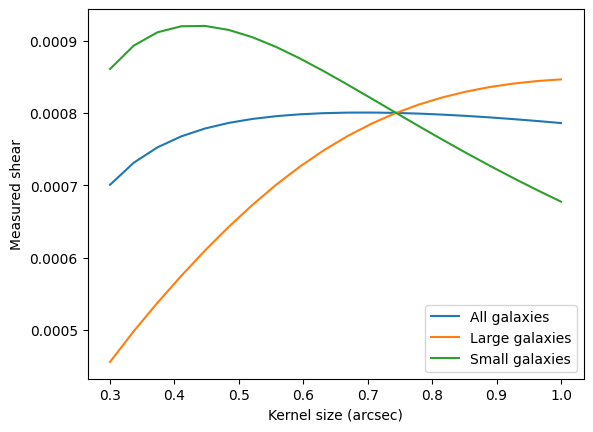

In [60]:
plt.plot(kernels, sample_shears, label='All galaxies')
plt.plot(kernels, larger_shears, label='Large galaxies')
plt.plot(kernels, smaller_shears, label='Small galaxies')
plt.xlabel('Kernel size (arcsec)')
plt.ylabel('Measured shear')
plt.legend()

In [83]:
print(kernels[0], kernels[-1])

0.3 1.0


In [85]:
print(sample_shears[0]/sample_shears[-1])
print(larger_shears[0]/larger_shears[-1])
print(smaller_shears[-1]/smaller_shears[0])
print

0.8913796100163586
0.5382585238297951
0.7868275796810511


<function print(*args, sep=' ', end='\n', file=None, flush=False)>

Text(0.5, 1.0, 'Galaxies with HLR > 1.0050000000000001 arcsec')

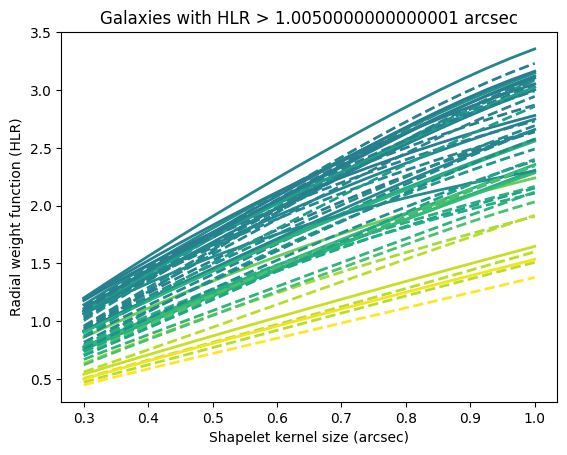

In [90]:
# create color map based on galaxy 
# half light radius
minima = min(hlrs)
maxima = max(hlrs)

norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.viridis)

hlr_cut = 1.5*seeing
for i in range(ngals):
    if hlrs[i] > hlr_cut:
        if i % 1 == 0:
            color = mapper.to_rgba(hlrs[i])
            if use_bulge[i]:
                plt.plot(kernels, rwfs[:,i], label=f'Galaxy {i}', c=color, lw=2, ls='--')
            else:
                plt.plot(kernels, rwfs[:,i], label=f'Galaxy {i}', c=color, lw=2, ls='-')
plt.xlabel('Shapelet kernel size (arcsec)')
plt.ylabel('Radial weight function (HLR)')
plt.title('Galaxies with HLR > {} arcsec'.format(hlr_cut))

Radial weight function (defined as a ratio of measurement radius to half light radius) with shapelet kernel size. Each line represents an individual galaxy and is coloured proportional to it's half-light radius.

### Investigate Correlation with galaxy properties

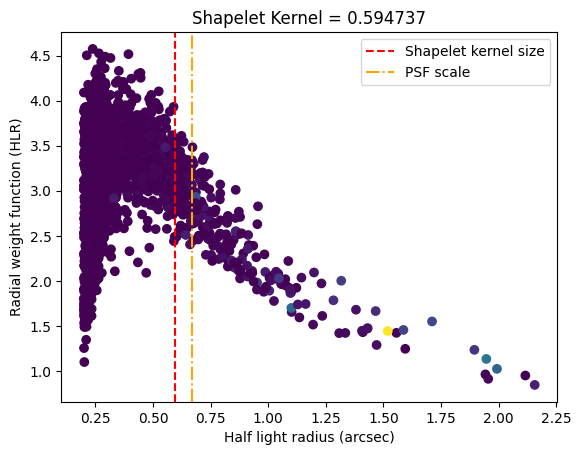

In [91]:
# Pick middle kernel size
i = -12
plt.figure()
plt.title('Shapelet Kernel = {:3f}'.format(kernels[i]))
plt.scatter(hlrs, rwfs[i,:], marker='o', c=fluxes, cmap='viridis')
plt.axvline(kernels[i], ls='--', c='r', label='Shapelet kernel size')
plt.axvline(seeing, ls='-.', c='orange', label='PSF scale')
plt.legend()
plt.xlabel('Half light radius (arcsec)')
plt.ylabel('Radial weight function (HLR)')
plt.savefig('plots/rwf_vs_hlr.png')

Radial weight function (defined as a ratio of measurement radius to half light radius) v.s. the half light radius of the galaxy. Points represent individual galaxies and are coloured proportional to their flux.

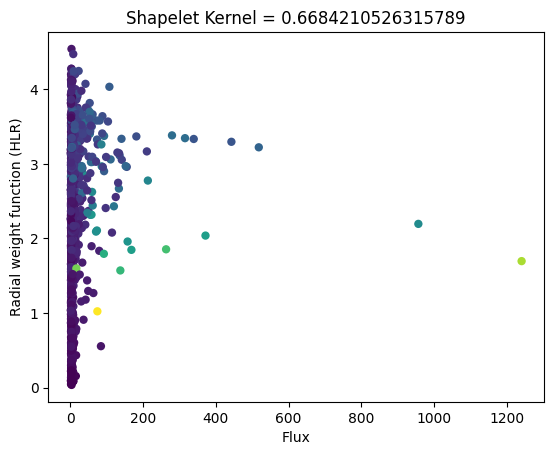

In [367]:
plt.figure()
plt.title('Shapelet Kernel = {}'.format(kernels[i]))
plt.scatter(fluxes, rwfs[i,:], lw=0, marker='o', c=hlrs, cmap='viridis')
plt.xlabel('Flux')
plt.ylabel('Radial weight function (HLR)')
plt.savefig('plots/rwf_vs_flux.png')

Radial weight function (defined as a ratio of measurement radius to half light radius) v.s. the flux of the galaxy. Points represent individual galaxies and are coloured proportional to their half light radius.

### Swap the order of MEM estimators above a certain scale?